# Absorption résonante

# Une approche Monte Carlo de l'absorption résonante

Nous ne considérerons que la variable énergétique.  
En partant d'une source située en $E = 1$ Mev, modélisez via la méthode de Monte Carlo, le ralentissement dans un milieu ressemblant à l'hydrogène (collision élastique avec $A=1$) avec absorbant pur (dont la section efficace est négligeable en dehors de la résonance).   
Utilisez une source de 10 000 neutrons.  
Tracer le spectre en fonction de l'énergie.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field


@dataclass
class NuclearData:
    elastic_xs: float = 1.0
    capture_xs: float = 0.0
    energie_resonance: float = 0.5
    largeur_resonance: float = 0.01
    hauteur_resonance: float = 1e8
    atomic_weight_ratio: float = 1.0
    resonance_limits: tuple[float] = field(init=False)

    def __post_init__(self):
        self.resonance_limits = (
            self.energie_resonance - self.largeur_resonance / 2.0,
            self.energie_resonance + self.largeur_resonance / 2.0,
        )

    def get_xs(self, reaction_type, energy):
        if reaction_type.lower() == "elastic":
            return self._get_elastic_xs(energy)
        if reaction_type.lower() == "capture":
            return self._get_capture_xs(energy)
        if reaction_type.lower() == "total":
            return self._get_total_xs(energy)
        raise ValueError(
            f"Reaction {reaction_type} is not accepted. Accepted values are: elastic, capture or total"
        )

    def _get_elastic_xs(self, energy):
        return self.elastic_xs

    def _get_capture_xs(self, energy):
        if self.resonance_limits[0] < energy and energy < self.resonance_limits[1]:
            return self.hauteur_resonance
        else:
            return self.capture_xs

    def _get_total_xs(self, energy):
        return self._get_capture_xs(energy) + self._get_elastic_xs(energy)

<>:65: SyntaxWarning: invalid escape sequence '\S'
<>:65: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipykernel_413787/1809253443.py:65: SyntaxWarning: invalid escape sequence '\S'
  plt.loglog(intervalles,score_total,'.-',label='A={} $ \Sigma_a $={:.2f}'.format(A, sigma_a))
100%|██████████| 1000000/1000000 [00:54<00:00, 18386.30it/s]


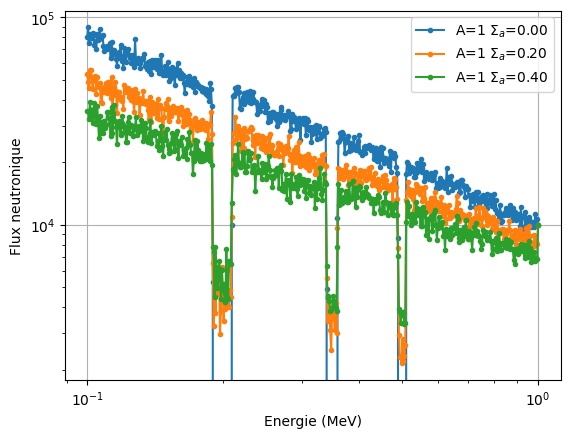

100%|██████████| 1000000/1000000 [00:54<00:00, 18251.68it/s]


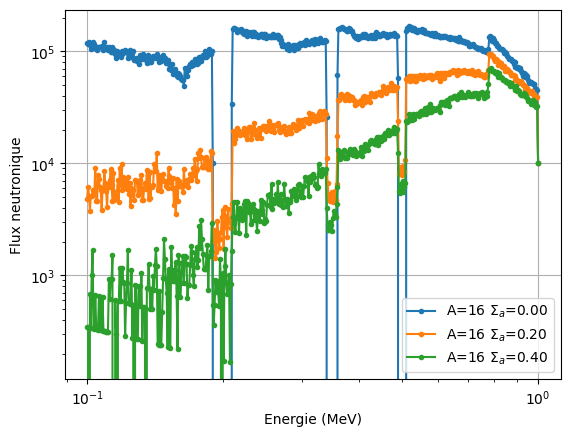

In [ ]:
import multiprocessing
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
processes=multiprocessing.cpu_count()


def evolution_neutron(args):
    E_source, E_lower_limit, alpha, intervalles, Proba_absorption = args
    energie=E_source
    score_local = np.zeros(len(intervalles))

    energie_resonance=[0.5,0.35,0.2]
    score_local[-1] += 1  # Compter le neutron initial dans le dernier intervalle

    while energie>E_lower_limit:
        energie=rng.uniform(alpha*energie,energie)
        # On regarde si l'énergie du neutron est proche d'une énergie de résonance et si c'est le cas, il a une proba d'être absorbé
        if any(abs(energie - E_r) < 0.01 for E_r in energie_resonance) and rng.uniform(0,1)<1-Proba_absorption:
            break

        if rng.uniform(0,1)<Proba_absorption:
            break
        index_intervalle = np.searchsorted(intervalles, energie) - 1
        if 0 <= index_intervalle < len(score_local):
            score_local[index_intervalle] += 1
    return(score_local)


E_lower_limit = 1e-1
rng = np.random.default_rng(0)
N_neutrons = 1000000
E_source = 1.0
Proba_absorption=0.5

N_source = 1e4

nb_intervalle=500
intervalles=np.logspace(np.log10(E_lower_limit),np.log10(E_source),nb_intervalle) # intervalles en logarithme
intervalles_MC_abs=intervalles


LA=[1,16]
L_sigma_a=list(np.arange(0,0.6,0.2))

L_phi_MC_abs=[]
for A in LA:
    for sigma_a in L_sigma_a:
        alpha=((A-1)/(A+1))**2

        # sigma_a=0
        sigma_s=1.0
        sigma_t=sigma_s+sigma_a

        Proba_absorption = sigma_a / sigma_t
        

        with Pool(processes) as pool:
            results = list(tqdm(pool.imap(evolution_neutron, [(E_source, E_lower_limit, alpha, intervalles, Proba_absorption)] * N_neutrons), total=N_neutrons))

        score_total = np.sum(results, axis=0)
        score_total[:-1] /= np.diff(intervalles)
        score_total*= N_source/N_neutrons


        plt.loglog(intervalles,score_total,'.-',label='A={} $ \Sigma_a $={:.2f}'.format(A, sigma_a))
        # plt.plot(intervalles[:-1],score_total,'o-',label='A={} P_abs={:.1f}'.format(A, Proba_absorption))
        # plt.semilogx(intervalles[:-1],score_total,'o-',label='A={}'.format(A))
        L_phi_MC_abs.append(score_total)
    plt.legend()
    plt.grid()
    plt.xlabel('Energie (MeV)')
    plt.ylabel('Flux neutronique')
    plt.show(block=False)